### 0. Import libraries

In [124]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.tensorboard import SummaryWriter

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

# save data values 
import pickle

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem

from sandiapv_energy_prediction import *
import optuna


## 1. Define model

In [125]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values= None):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_rnn1 = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        #self.dynamic_rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Increased depth in fully connected layers
        self.fc1 = nn.Linear(hidden_size + static_feature_size, 2*fc_size)  
        self.fc2 = nn.Linear(2*fc_size, fc_size)
        self.fc3 = nn.Linear(fc_size, 24)
        
        self.gelu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid() 

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

        # Load dataset values
        self.dynamic_cols = dynamic_feature_size

        # values for inference
        self.mean = dataset_values['mean']
        self.std = dataset_values['std']
        self.min = dataset_values['output_mins']
        self.max = dataset_values['output_maxs']
            
    def forward(self, dynamic_features, static_features):
        # Two LSTM layers
        output,(h_n,_)  = self.dynamic_rnn1(dynamic_features)
        #output, (h_n, _) = self.dynamic_rnn2(output)
        h_n = h_n.squeeze(0)
        
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
        x = self.fc1(concatenated_features)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        output =  self.sigmoid(x)
        
        return output
    
    def predict(self, x_dynamic, x_static):
        static_dim = x_static.shape[1] -1
        print(static_dim)
        # Print input shapes for debugging
        print('input', x_dynamic.shape, x_static.shape)
        print('dynamic cols value', self.dynamic_cols)
        
        # Ensure x_static and x_dynamic are torch tensors and are of correct type
        x_static = torch.tensor(x_static, dtype=torch.float32)
        x_dynamic = torch.tensor(x_dynamic, dtype=torch.float32)
        
        # Print shapes after conversion to tensors
        print('shape x_static, x_dynamic', x_static.shape, x_dynamic.shape)

        # Normalize static features
        static_mean = torch.tensor(self.mean[:static_dim] + [0], dtype=torch.float32)
        static_std = torch.tensor(self.std[:static_dim] + [1], dtype=torch.float32)
        x_static_norm = (x_static - static_mean) / static_std
        
        # Print normalized static features
        print('x_static_norm', x_static_norm.shape, x_static_norm)

        # Normalize dynamic features
        dynamic_mean = torch.tensor(self.mean[static_dim:], dtype=torch.float32).reshape(1, -1)
        dynamic_std = torch.tensor(self.std[static_dim:], dtype=torch.float32).reshape(1, -1)
        x_dynamic_norm = (x_dynamic - dynamic_mean) / dynamic_std

        # Print normalized dynamic features
        print('x_dynamic_norm', x_dynamic_norm.shape, x_dynamic_norm)

        # Switch model to evaluation mode
        self.eval()

        # Perform inference
        with torch.no_grad():
            normalized_output = self.forward(x_dynamic_norm, x_static_norm)

        # Denormalize the output if needed
        denormalized_output = normalized_output * (self.max - self.min) + self.min
        return denormalized_output

## 2. Define training class


In [126]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size,fc_size, learning_rate, loss_type='mse',dataset_values= None):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values= dataset_values)

        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='sum')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='sum')
        elif loss_type == 'huber':
            self.loss_fn = nn.HuberLoss(reduction='sum', delta=1.0)
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'nll'.")

        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.train_auc = []
        self.validation_auc = []
        self.train_r2 = []
        self.val_r2 = []
        self.learning_rate = learning_rate
        
    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)

    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
 
        y_pred = self(x_dynamic, x_static)
 
        train_loss = self.loss_fn(y_pred, y_true)
        self.train_losses.append(train_loss.item())
        sum_loss = nn.L1Loss(reduction='sum')(y_pred, y_true)
        
    
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        self.train_auc.append(auc_ratio.item())

        # Calculate R^2 score
        r2 = self.r2_score(y_true, y_pred)
        self.train_r2.append(r2.item())

        # Log metrics   
        self.log('train_auc', auc_ratio, on_step=True, on_epoch=True, logger=True)
        self.log('train_loss', train_loss, on_step=True, on_epoch=True,  logger=True)
        self.log('train_l1_sum', sum_loss, on_step=False, on_epoch=True,  logger=True)
        self.log('train_r2_score', r2, on_step=True, on_epoch=True)
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        val_loss = self.loss_fn(y_pred, y_true)
        self.validation_losses.append(val_loss.item()) 
        val_eval_metric = nn.L1Loss(reduction='mean')(y_pred, y_true)
        

        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        self.validation_auc.append(auc_ratio.item())

        # Calculate R^2 score
        r2 = self.r2_score(y_true, y_pred)
        self.val_r2.append(r2.item())

        # Log metrics
        self.log('validation_auc', auc_ratio, on_step=True, on_epoch=True, logger=True)
        self.log('val_train_loss', val_loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_evaluation_metric', val_eval_metric, on_step=False, on_epoch=True,  logger=True) 
        self.log('val_r2_score', r2, on_step=True, on_epoch=True)

        return val_eval_metric
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        test_loss = self.loss_fn(y_pred, y_true)
        sum_loss = nn.L1Loss(reduction='sum')(y_pred, y_true)
        
        # Calculate AUC for predictions and ground truth
        auc_pred = self.calculate_auc(y_pred)
        auc_gt = self.calculate_auc(y_true)
        auc_ratio = auc_pred / auc_gt if auc_gt != 0 else 0

        # Calculate R^2 score
        r2 = self.r2_score(y_true, y_pred)

        # Log metrics
        self.log(f'Total test_loss', test_loss)
        self.log(f'Total L1 loss', sum_loss)
        self.log(f'Total auc_ratio', auc_ratio)
        self.log('test_r2_score', r2,)
        self.test_losses.append(test_loss.item())
        
        return {
            'test_loss': test_loss,
            'sum_l1_loss': sum_loss,
            'auc_ratio': auc_ratio,
            'test_r2_score': r2,
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer
    
    def calculate_auc(self, y_values):
        y_values = y_values.detach().numpy()
        auc = np.trapz(y_values, axis=1)
        return np.mean(auc)

    def r2_score(self,y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [127]:
CONVERTER = {
    'temperature_sequence': ast.literal_eval, 
    'wind_speed_sequence': ast.literal_eval, 
    'dni_sequence': ast.literal_eval, 
    'dhi_sequence': ast.literal_eval, 
    'global_irradiance_sequence': ast.literal_eval,
    'energy_data': ast.literal_eval,
}

class SolarPanelDataset(Dataset):
    def __init__(self, synthetic_csv, measurement_csv, transform=None, sequence_length=24):
        self.sequence_length = sequence_length
        self.mean = []
        self.std =[]
        self.dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        self.static_cols = ['tilt', 'azimuth' ]   
        self.features = self.dynamic_cols + self.static_cols 
        
        # Load data from both CSVs
        self.synthetic_data = pd.read_csv(synthetic_csv, converters=CONVERTER)  
        self.measurement_data = pd.read_csv(measurement_csv, converters=CONVERTER) 
        
        # Optionally apply transformations/pre-processing
        self.transform = transform
        
        # Combine data for easy shuffling and splitting
        self.synthetic_data['data_type'] = 'synthetic'
        self.measurement_data['data_type'] = 'measurement'
        self.data_frame = pd.concat([self.synthetic_data, self.measurement_data], ignore_index=True)
        
        # Encode string to int
        self.data_frame['module_type'] = LabelEncoder().fit_transform(self.data_frame['module_type'])
        
        # Ensure all sequences are of the same length
        self.pad_or_truncate_sequences()

        self.normalize_features()
        self.normalize_outputs()

    def pad_or_truncate_sequences(self):
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            self.data_frame[col] = self.data_frame[col].apply(self.pad_or_truncate)

    def pad_or_truncate(self, sequence):
        if len(sequence) > self.sequence_length:
            return sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
            return sequence + [0.0] * (self.sequence_length - len(sequence))
        return sequence

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output
    
    def normalize_features(self):
        # Normalize static numeric features
        for feature in self.static_cols:
            mean = self.data_frame[feature].mean()
            self.mean.append(mean)
            std = self.data_frame[feature].std()
            self.std.append(std)
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        for col in self.dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            self.mean.append(mean)
            std = col_data.std()
            self.std.append(std)
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        energy_array = np.array(self.data_frame['energy_data'].tolist())
        self.output_mins = energy_array.min(axis=0)
        self.output_maxs = energy_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (energy_array - self.output_mins) / range
        self.data_frame['energy_data'] = list(normalized_gaussian)


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features, dtype=torch.float32)
        
        # Dynamic features
        dynamic_features = np.array([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)

        # Transpose to get shape (sequence_length, number_of_features)
        dynamic_features = dynamic_features.T

        # Outputs
        outputs = torch.tensor(self.data_frame.iloc[idx]['energy_data'], dtype=torch.float32)

        return dynamic_features, static_features, outputs

In [128]:
def create_data_loaders(dataset, synthetic_sampling_ratio, measured_split_ratio, synthetic_split_ratio, val_ratio, batch_size):
    # Split dataset into synthetic and measured data
    synthetic_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'synthetic']
    measured_indices = [i for i in range(len(dataset)) if dataset.data_frame.iloc[i]['data_type'] == 'measurement']

    print('size of the total dataset:', len(dataset), '\n'
          'size of synthetic data:', len(synthetic_indices), f'= {len(synthetic_indices)/len(dataset):.2f}\n' 
          'size of the measured data:', len(measured_indices), f'= {len(measured_indices)/len(dataset):.2f}\n')
    
    total_synthetic_count = int(synthetic_sampling_ratio * len(synthetic_indices))
    total_measured_count = len(measured_indices)

    print('size of the total dataset after subsampling:', total_synthetic_count + total_measured_count, '\n',
          'Size of synthetic data:', total_synthetic_count, f'= {total_synthetic_count / (total_synthetic_count + total_measured_count):.2f} \n', 
          'Size of the measured data:', total_measured_count, f'= {total_measured_count / (total_synthetic_count + total_measured_count):.2f} \n',
          '________________________________________________________\n')
    
    synthetic_data = Subset(dataset, synthetic_indices[:total_synthetic_count])
    measured_data = Subset(dataset, measured_indices[:total_measured_count])

    # Split synthetic data into training, validation, and testing
    synthetic_train_count = int(synthetic_split_ratio * total_synthetic_count)
    synthetic_val_count = int(val_ratio * synthetic_train_count)
    synthetic_train_count -= synthetic_val_count
    synthetic_test_count = total_synthetic_count - synthetic_train_count - synthetic_val_count

    synthetic_train_data, synthetic_val_data, synthetic_test_data = random_split(
        synthetic_data, [synthetic_train_count, synthetic_val_count, synthetic_test_count])

    # Split measured data into training, validation, and testing
    measured_train_count = int(measured_split_ratio * total_measured_count)
    measured_val_count = int(val_ratio * measured_train_count)
    measured_train_count -= measured_val_count
    measured_test_count = total_measured_count - measured_train_count - measured_val_count

    measured_train_data, measured_val_data, measured_test_data = random_split(
        measured_data, [measured_train_count, measured_val_count, measured_test_count])

    # Combine training and validation data
    train_data = measured_train_data + synthetic_train_data
    val_data = measured_val_data + synthetic_val_data

    print('Training set size (synthetic):', synthetic_train_count, 
          f'= {synthetic_train_count / total_synthetic_count:.2f} of synthetic data')
    print('Training set size (measured):', measured_train_count, 
          f'= {measured_train_count / total_measured_count:.2f} of measured data \n')
    print('Validation set size (synthetic):', synthetic_val_count, 
          f'= {synthetic_val_count / total_synthetic_count:.2f} of synthetic data')
    print('Validation set size (measured):', measured_val_count, 
          f'= {measured_val_count / total_measured_count:.2f} of measured data \n')
    print('Test set size (synthetic):', synthetic_test_count, 
          f'= {synthetic_test_count / total_synthetic_count:.2f} of synthetic data')
    print('Test set size (measured):', measured_test_count, 
          f'= {measured_test_count / total_measured_count:.2f} of measured data \n')

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_synthetic_loader = DataLoader(synthetic_test_data, batch_size=batch_size, shuffle=False, num_workers=0)
    test_measurement_loader = DataLoader(measured_test_data, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_synthetic_loader, test_measurement_loader 

In [129]:
dataset = SolarPanelDataset('energy_data/dataset_to_train_model2.csv', 'energy_data/merged_solar_weather_data2.csv')

# Parameters
BATCHSIZE = 64

# Assuming dataset is already defined
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,    # 30% of the synthetic dataset
    measured_split_ratio=0.6,      # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,     # 70% of the synthetic dataset for training
    val_ratio=0.2,                 # 10% of the training data for validation
    batch_size=BATCHSIZE
    )

# Example of iterating through the train loader
for i, data in enumerate(train_loader):
    if i > 1:
        break
    dynamic_inputs, static_inputs, outputs = data
    print('shapes, dynamic,static,outputs:', dynamic_inputs.shape, static_inputs.shape, outputs.shape)
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs)

size of the total dataset: 13839 
size of synthetic data: 12497 = 0.90
size of the measured data: 1342 = 0.10

size of the total dataset after subsampling: 13839 
 Size of synthetic data: 12497 = 0.90 
 Size of the measured data: 1342 = 0.10 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 644 = 0.48 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 161 = 0.12 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 537 = 0.40 of measured data 

shapes, dynamic,static,outputs: torch.Size([64, 24, 5]) torch.Size([64, 3]) torch.Size([64, 24])
Static Inputs: tensor([[ 1.1849,  1.3878,  0.0000],
        [-0.5051, -1.5843,  0.0000],
        [-0.3984, -0.4715,  1.0000],
        [ 1.1325, -0.2736,  0.0000],
        [-2.1974, -1.1957,  0.0000],
        [-1.0693, -0.0505,  0.0000],
     

## 4. Train model

In [130]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 8 #8 #
fc_size = 128 #128
learning_rate = 0.001070528640534469# 1e-3
loss_type = 'huber' #'huber'
epochs = 5


dataset_values = {'mean': dataset.mean,
                'std': dataset.std,
                'output_mins': dataset.output_mins,
                 'output_maxs': dataset.output_maxs}


# Initialize the Lightning module  
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size,fc_size, learning_rate, loss_type=loss_type,dataset_values=dataset_values)
model = train_module.model 
print(model)

EnergyPredictionModel(
  (dynamic_rnn1): LSTM(5, 8, batch_first=True)
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (gelu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)


In [131]:
# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
#print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs, 
                     logger =logger,)
#print(trainer)
# Fit the model to the training data
trainer.fit(train_module, 
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,
            )
trained_model = train_module.model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 39.5 K
1 | loss_fn | HuberLoss             | 0     
--------------------------------------------------
39.5 K    Trainable params
0         Non-trainable params
39.5 K    Total params
0.158     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Inspect performance

[115.863037109375, 107.54580688476562, 112.02086639404297, 109.10446166992188, 101.4588851928711, 96.67808532714844, 92.55191802978516, 89.86231994628906, 89.71377563476562, 72.50950622558594, 74.10107421875, 65.67266082763672, 60.30561828613281, 52.5544319152832, 50.16611862182617, 44.66044998168945, 39.095218658447266, 35.26491165161133, 31.99469566345215, 26.320701599121094, 22.037696838378906, 21.440011978149414, 17.815216064453125, 15.891233444213867, 18.073095321655273, 12.293458938598633, 13.010282516479492, 14.039508819580078, 12.175280570983887, 16.634342193603516, 12.823278427124023, 13.658352851867676, 12.120774269104004, 13.560197830200195, 16.30556297302246, 14.876869201660156, 14.325661659240723, 15.627272605895996, 9.982336044311523, 12.663604736328125, 12.776388168334961, 15.194725036621094, 10.934353828430176, 12.243204116821289, 10.57707691192627, 10.972999572753906, 9.247594833374023, 13.043224334716797, 11.380487442016602, 9.612236976623535, 15.79776382446289, 8.899

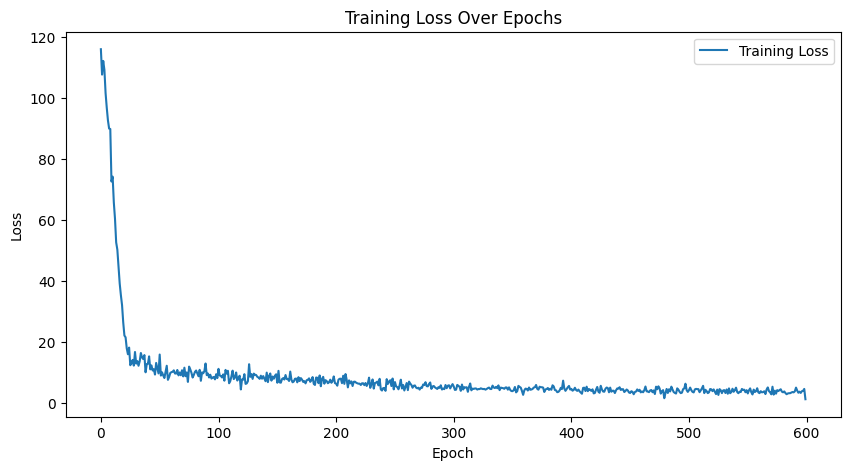

In [132]:
print(train_module.train_losses)
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[21.122126587231953, 7.369442522525787, 5.074951177835464, 4.232145804166794, 3.8263633449872336]
120


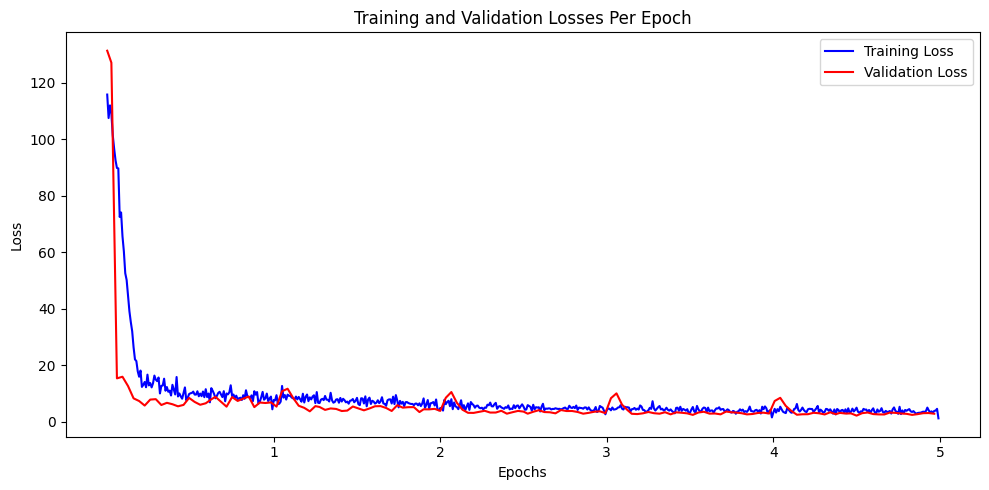

In [133]:
def plot_losses_per_epoch(train_losses, val_losses, num_epochs=5, log_scale=False):
    fig, ax = plt.subplots(figsize=(10, 5))

    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)
    #range_val_loses = range(len_val_losses)
    print(len_val_losses, len_train_losess)

    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]
    print(range_val_loses)
    iterations_per_epoch = len(train_losses) // num_epochs

    epoch_train_losses = [
        np.mean(train_losses[int(i * iterations_per_epoch):int((i + 1) * iterations_per_epoch)])
        for i in range(num_epochs)
    ]

    print(epoch_train_losses)
    print(iterations_per_epoch)

    epochs = np.arange(1, num_epochs + 1)

    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training Loss', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation Loss', color='r')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Losses Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_losses_per_epoch(train_module.train_losses, train_module.validation_losses)

152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[1.298558662335078, 1.0087125574549038, 1.0051903173327446, 1.0031448796391487, 1.0033259948094686]
120


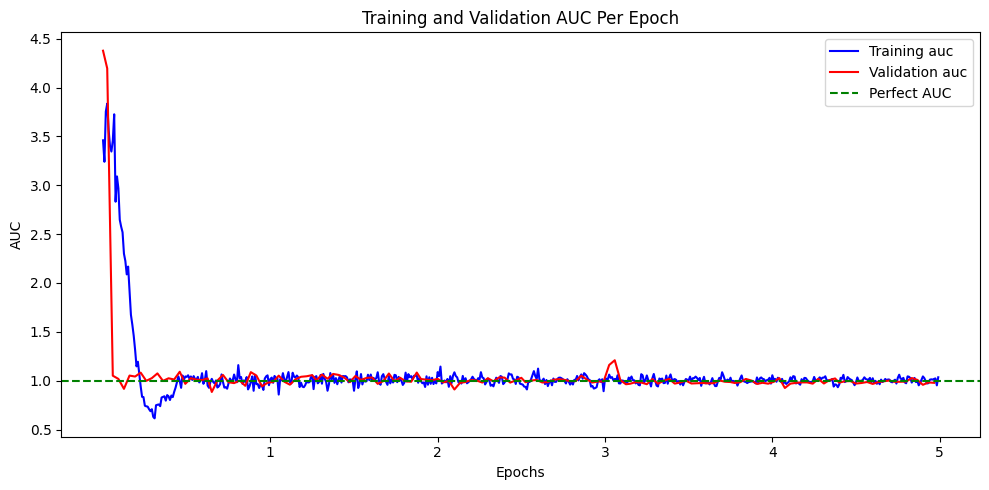

In [134]:
def plot_aucs(train_losses, val_losses, num_epochs=5, log_scale=False):
    fig, ax = plt.subplots(figsize=(10, 5))

    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)
    #range_val_loses = range(len_val_losses)
    print(len_val_losses, len_train_losess)

    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]
    print(range_val_loses)
    iterations_per_epoch = len(train_losses) // num_epochs

    epoch_train_losses = [
        np.mean(train_losses[int(i * iterations_per_epoch):int((i + 1) * iterations_per_epoch)])
        for i in range(num_epochs)
    ]

    print(epoch_train_losses)
    print(iterations_per_epoch)

    epochs = np.arange(1, num_epochs + 1)

    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training auc', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation auc', color='r')
    ax.axhline(y=1, color='g', linestyle='--', label='Perfect AUC')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('AUC')
    ax.set_title('Training and Validation AUC Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_aucs(train_module.train_auc, train_module.validation_auc)

152 600
[0, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 303, 307, 311, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 367, 371, 375, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 434, 438, 442, 446, 450, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596]
[-0.03381775865952174, 0.6359409173329671, 0.7494737659891446, 0.7912104919552803, 0.8109716539581616]
120


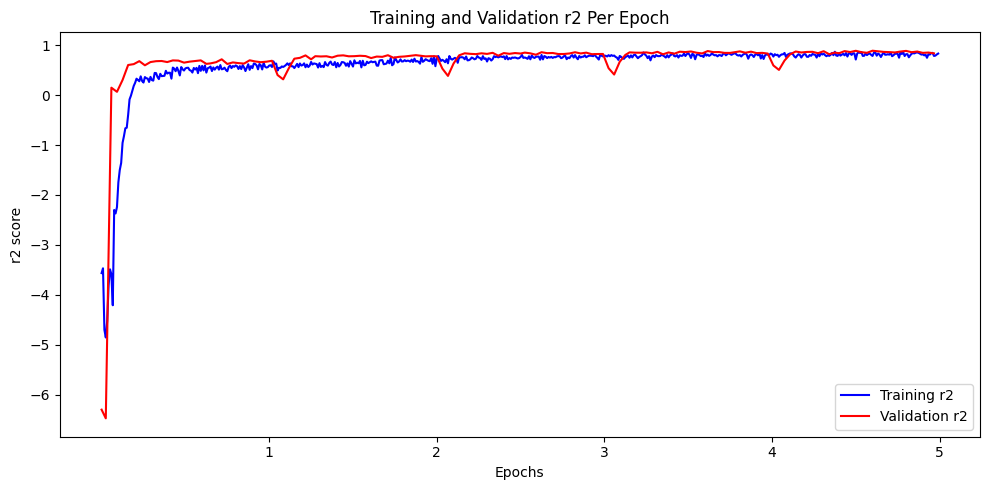

In [135]:
def plot_aucs(train_losses, val_losses, num_epochs=5, log_scale=False):
    fig, ax = plt.subplots(figsize=(10, 5))

    len_val_losses = len(val_losses)
    len_train_losess = len(train_losses)
    range_train_loses = range(len_train_losess)
    #range_val_loses = range(len_val_losses)
    print(len_val_losses, len_train_losess)

    range_val_loses = [x *len_train_losess // len_val_losses for x in range(len_val_losses) ]
    print(range_val_loses)
    iterations_per_epoch = len(train_losses) // num_epochs

    epoch_train_losses = [
        np.mean(train_losses[int(i * iterations_per_epoch):int((i + 1) * iterations_per_epoch)])
        for i in range(num_epochs)
    ]

    print(epoch_train_losses)
    print(iterations_per_epoch)

    epochs = np.arange(1, num_epochs + 1)

    tick_positions  = [(i + 1) * len_train_losess//5 for i in range(5)]
    tick_labels =  [str(i + 1) for i in range(num_epochs)]
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.plot(range_train_loses,train_losses, label='Training r2', color='b')
    ax.plot(range_val_loses, val_losses, label='Validation r2', color='r')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('r2 score')
    ax.set_title('Training and Validation r2 Per Epoch')
    ax.legend()

    
    if log_scale:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_aucs(train_module.train_r2, train_module.val_r2)

#### Launch tensorboard for advanced training insights

In [136]:
# #Launch tensorboard for advanced training insights.
# os.system(f"taskkill /pid 19988 /F")

# # Reload the TensorBoard extension to avoid errors about it being already loaded
# %reload_ext tensorboard

# # Start TensorBoard
# %tensorboard --logdir tb_logs/my_model




## Test model

In [137]:
# Assuming you have two dataloaders initialized
dataloaders = [test_synthetic_loader, test_measurement_loader]
trainer.test(train_module, dataloaders=dataloaders)

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │     54.82946014404297     │     80.41156005859375     │
│      Total auc_ratio      │    0.9882591366767883     │    1.0013368129730225     │
│      Total test_loss      │     2.843698740005493     │     6.740030288696289     │
│       test_r2_score       │    0.8613580465316772     │     0.570185124874115     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'Total test_loss/dataloader_idx_0': 2.843698740005493,
  'Total L1 loss/dataloader_idx_0': 54.82946014404297,
  'Total auc_ratio/dataloader_idx_0': 0.9882591366767883,
  'test_r2_score/dataloader_idx_0': 0.8613580465316772},
 {'Total test_loss/dataloader_idx_1': 6.740030288696289,
  'Total L1 loss/dataloader_idx_1': 80.41156005859375,
  'Total auc_ratio/dataloader_idx_1': 1.0013368129730225,
  'test_r2_score/dataloader_idx_1': 0.570185124874115}]

### Inference with tested model

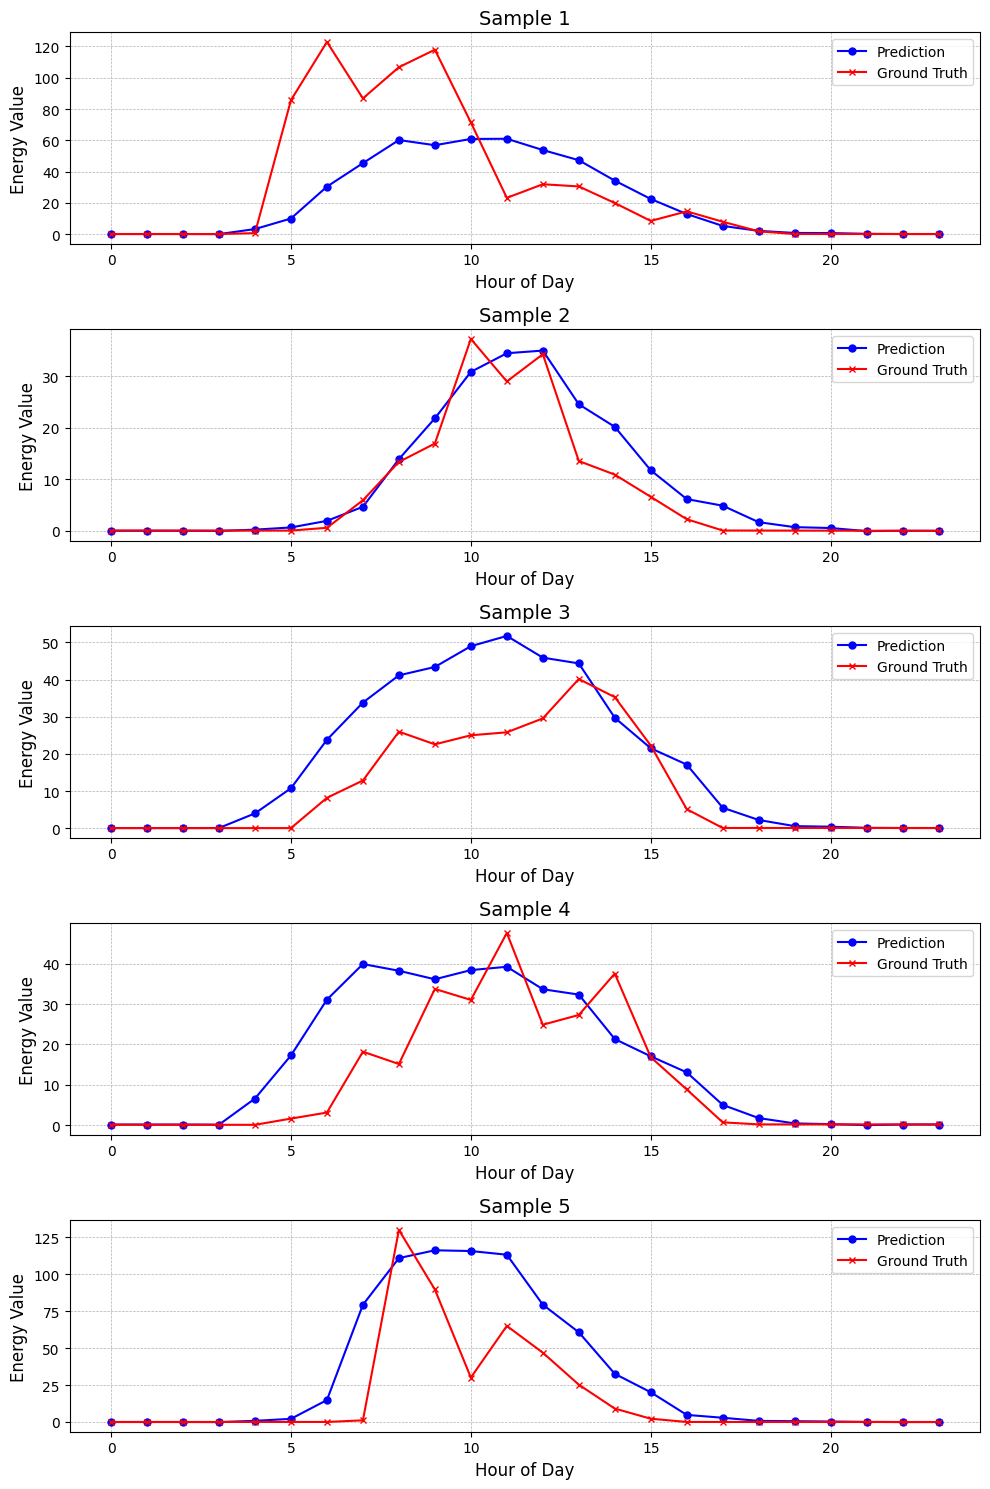

In [138]:
AMOUNT_OF_SAMPLES = 5
# Load the trained model
trained_model = train_module
trained_model.eval()

# Get a batch of samples from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(test_synthetic_loader))
sample_dynamic = sample_dynamic[:AMOUNT_OF_SAMPLES]
sample_static = sample_static[:AMOUNT_OF_SAMPLES]
ground_truth = ground_truth[:AMOUNT_OF_SAMPLES]

# Predict using the batch
with torch.no_grad():
    predictions = trained_model(sample_dynamic, sample_static).numpy()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Denormalize predictions and ground truth
predictions_denorm = denormalize(predictions, dataset)
ground_truth_denorm = denormalize(ground_truth.numpy(), dataset)

# Function to plot energy data
def plot_energy_data(predictions, ground_truth, num_samples=5):
    fig, axes = plt.subplots(AMOUNT_OF_SAMPLES, 1, figsize=(10, num_samples * 3))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        axes[i].plot(predictions[i], label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        axes[i].plot(ground_truth[i], label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        axes[i].set_title(f'Sample {i+1}', fontsize=14)
        axes[i].set_xlabel('Hour of Day', fontsize=12)
        axes[i].set_ylabel('Energy Value', fontsize=12)
        axes[i].legend()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the energy data for the specified number of samples
plot_energy_data(predictions_denorm, ground_truth_denorm, num_samples=AMOUNT_OF_SAMPLES)

#### Test on synthetic data

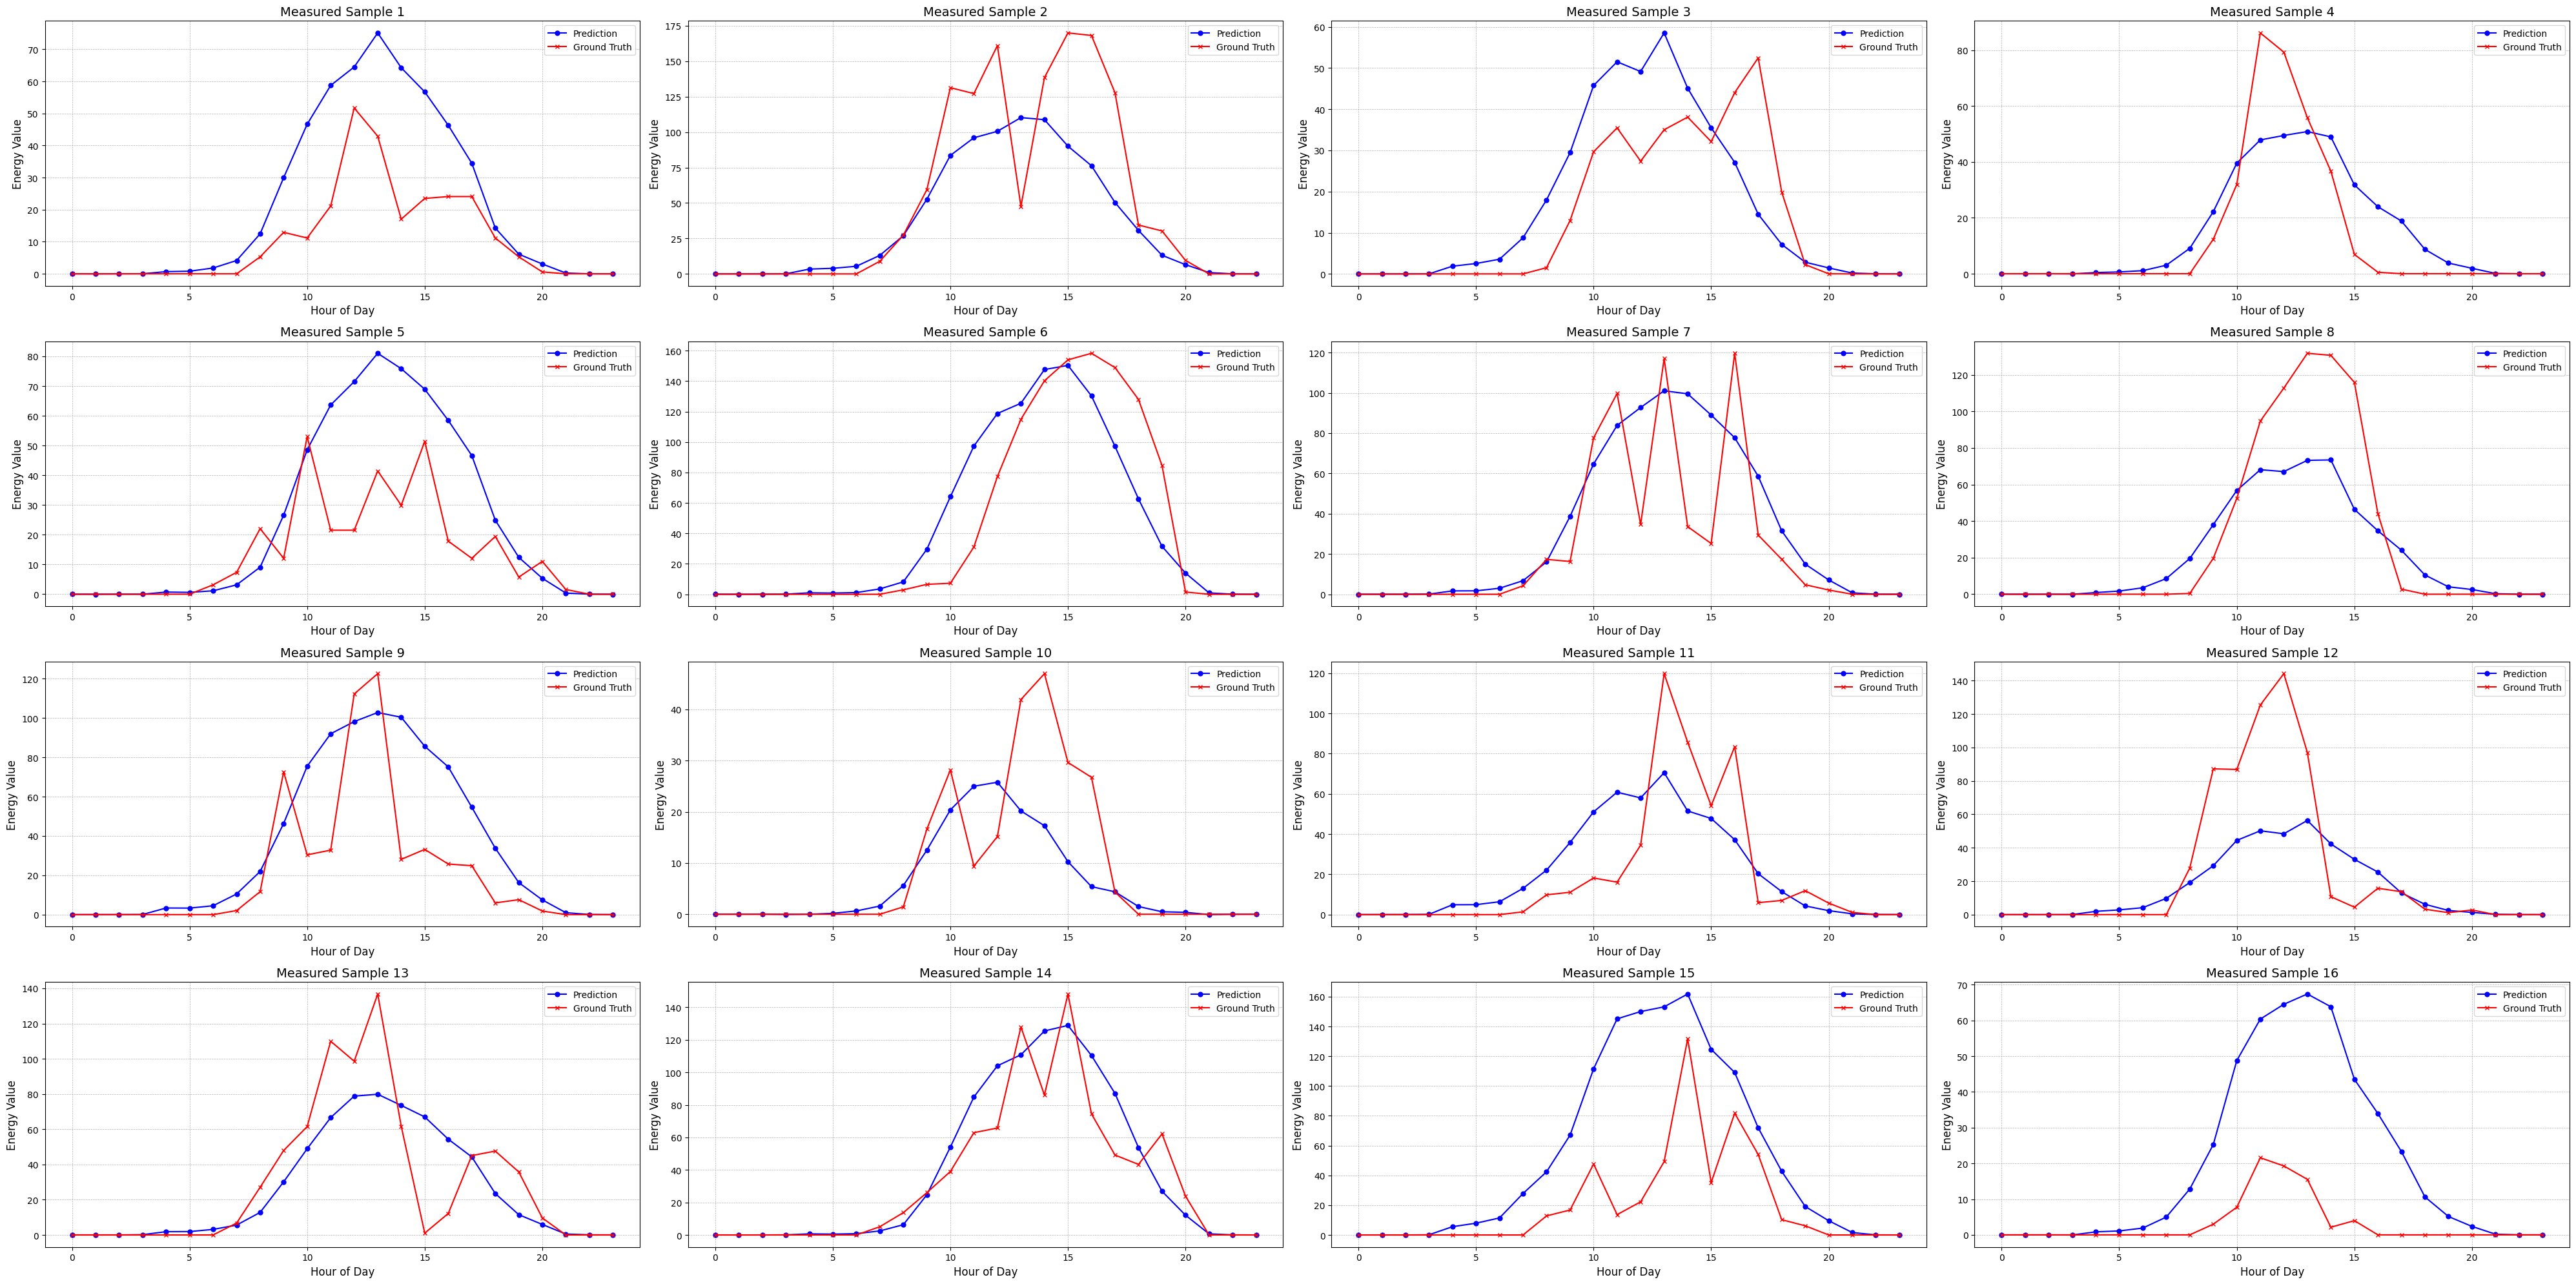

In [139]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(40, 20))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Measured Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Convert predictions and ground truth to numpy if still in tensor form
predictions = predictions
ground_truth = ground_truth

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

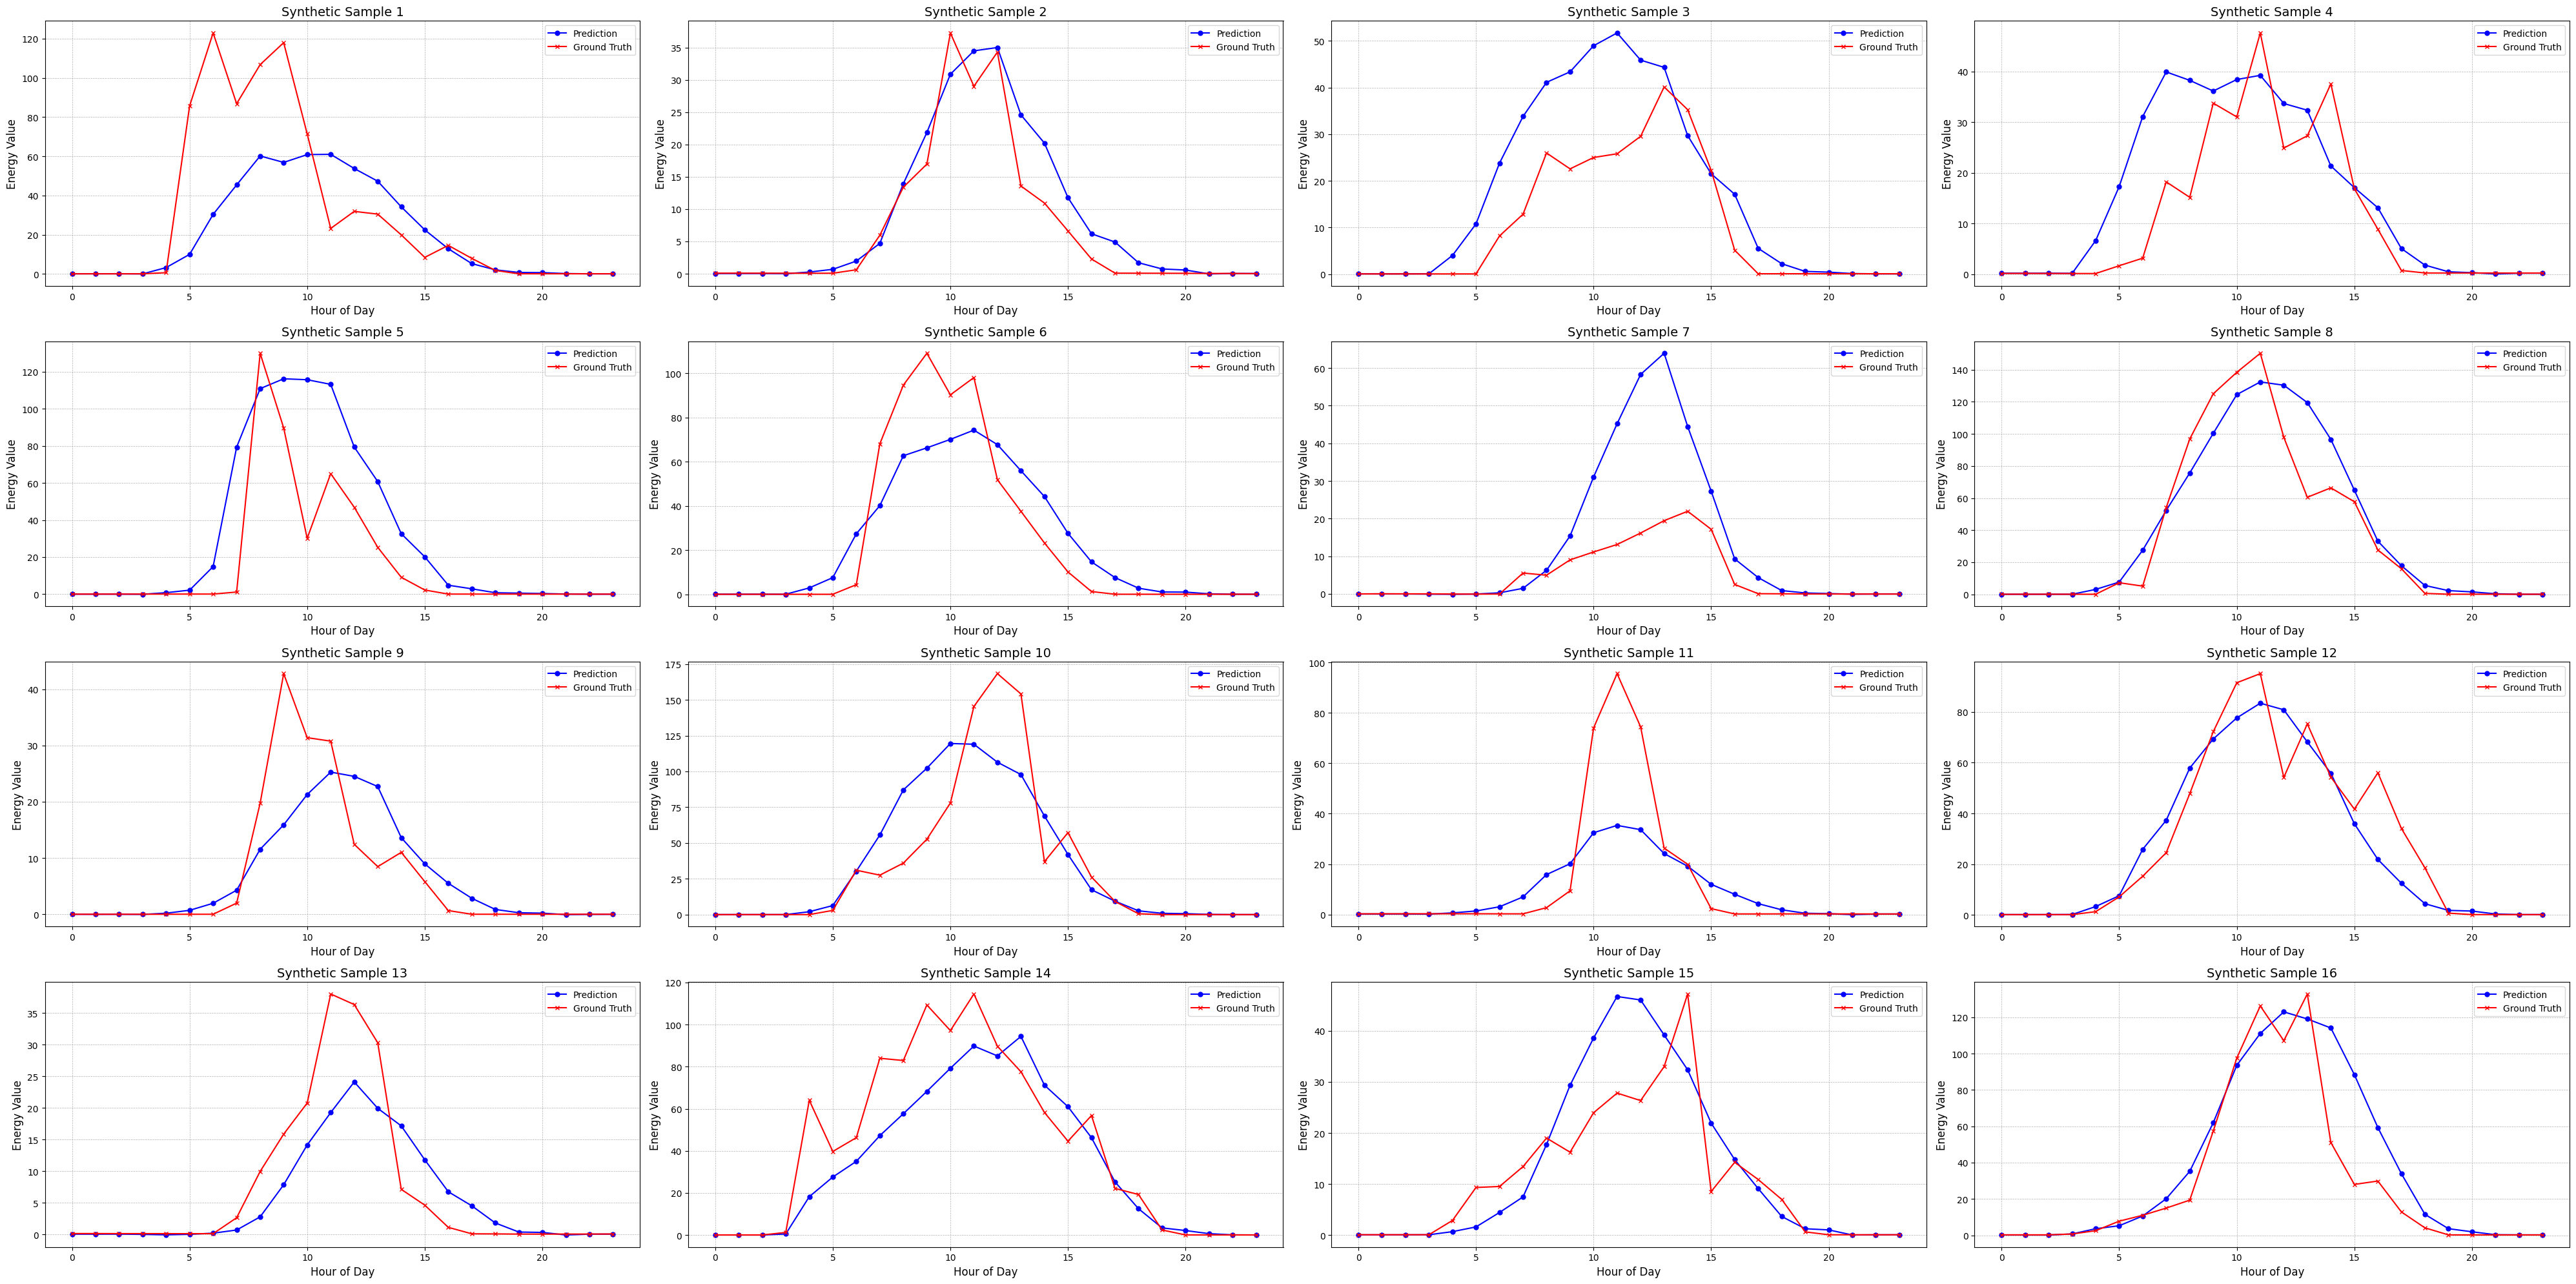

In [140]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(40, 20))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Synthetic Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Convert predictions and ground truth to numpy if still in tensor form
predictions = predictions
ground_truth = ground_truth

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

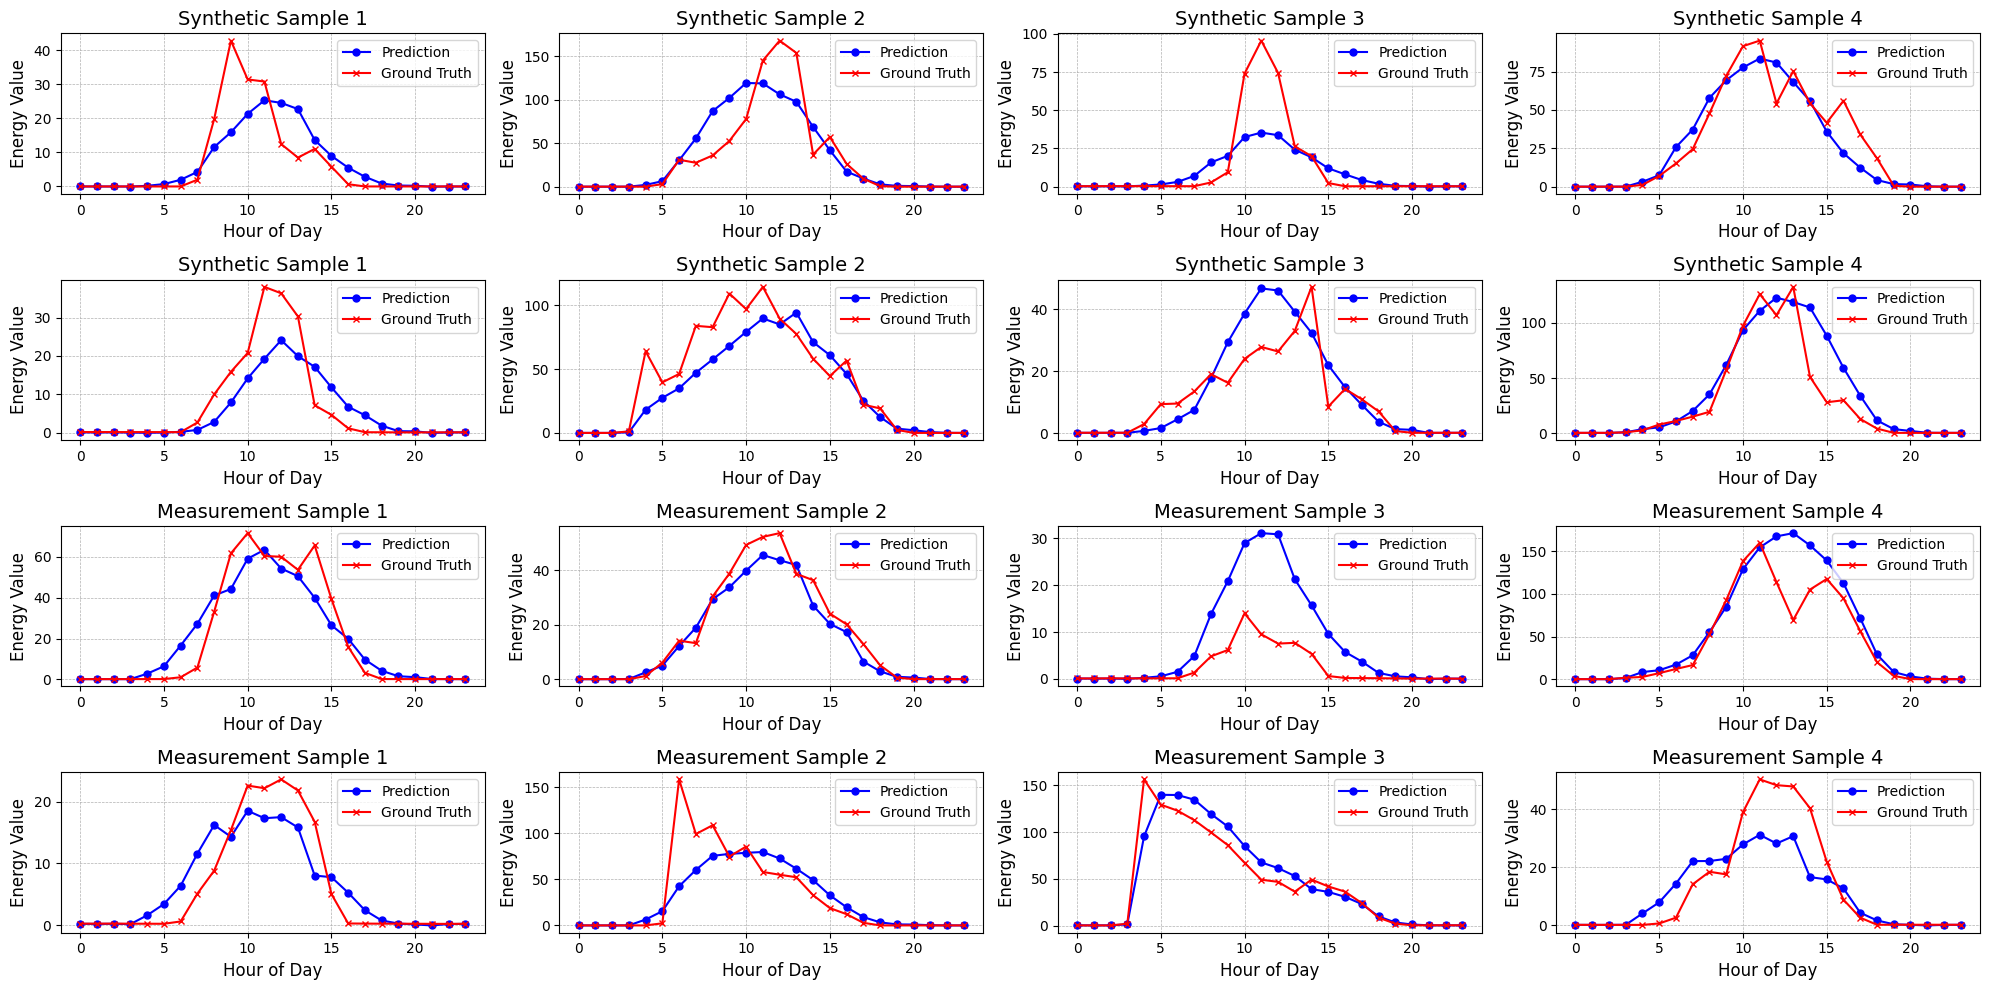

In [141]:
import matplotlib.pyplot as plt
import torch

# Load the trained model
trained_model = train_module
trained_model.eval()

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # Determine if the plot is for synthetic or measurement data
        if i < cols * 2:  # First two rows for synthetic data
            title_prefix = "Synthetic Sample"
        else:  # Last two rows for measurement data
            title_prefix = "Measurement Sample"

        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'{title_prefix} {i % cols + 1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot per category and subplots configuration
num_samples = 8  # Each category (synthetic, measurement) will have 4 samples
rows = 4
cols = 4

# Fetch samples from synthetic data loader
synthetic_dynamic, synthetic_static, synthetic_ground_truth = next(iter(test_synthetic_loader))
synthetic_dynamic = synthetic_dynamic[num_samples:]
synthetic_static = synthetic_static[num_samples:]
synthetic_ground_truth = synthetic_ground_truth[num_samples:]

# Fetch samples from measurement data loader
measurement_dynamic, measurement_static, measurement_ground_truth = next(iter(test_measurement_loader))
measurement_dynamic = measurement_dynamic[:num_samples]
measurement_static = measurement_static[:num_samples]
measurement_ground_truth = measurement_ground_truth[:num_samples]

# Predict using the synthetic samples
with torch.no_grad():
    synthetic_predictions = trained_model(synthetic_dynamic, synthetic_static)

# Predict using the measurement samples
with torch.no_grad():
    measurement_predictions = trained_model(measurement_dynamic, measurement_static)

# Combine predictions and ground truths
combined_predictions = torch.cat((synthetic_predictions, measurement_predictions))
combined_ground_truth = torch.cat((synthetic_ground_truth, measurement_ground_truth))

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples * 2, combined_predictions, combined_ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

## inference for Final model 

In [142]:
#save the model
torch.save(trained_model.model.state_dict(), 'final_models/energy_prediction_model.pth')

with open('final_models/dataset_values.pkl', 'wb') as f:
    pickle.dump(dataset_values, f)

2
input torch.Size([5, 24, 5]) torch.Size([5, 3])
dynamic cols value 5
shape x_static, x_dynamic torch.Size([5, 3]) torch.Size([5, 24, 5])
x_static_norm torch.Size([5, 3]) tensor([[-2.6731, -1.6913,  0.0000],
        [-2.6451, -1.6701,  0.0000],
        [-2.6906, -1.6950,  0.0000],
        [-2.6339, -1.6958,  0.0000],
        [-2.6855, -1.6843,  1.0000]])
x_dynamic_norm torch.Size([5, 24, 5]) tensor([[[-1.8440, -0.6069, -0.4995, -0.7269, -0.6430],
         [-1.8136, -0.6069, -0.4995, -0.7269, -0.6430],
         [-1.8250, -0.6076, -0.4995, -0.7269, -0.6430],
         [-1.8193, -0.6076, -0.4995, -0.7269, -0.6430],
         [-1.8174, -0.6069, -0.4995, -0.7266, -0.6430],
         [-1.7889, -0.6069, -0.4920, -0.7247, -0.6418],
         [-1.7282, -0.6069, -0.4887, -0.7223, -0.6380],
         [-1.6902, -0.6061, -0.4941, -0.7106, -0.6365],
         [-1.6465, -0.6061, -0.4917, -0.7102, -0.6330],
         [-1.6085, -0.6046, -0.4893, -0.7128, -0.6292],
         [-1.6256, -0.6038, -0.4986, -0.6892

C:\Users\denni\AppData\Local\Temp\ipykernel_29312\2900650543.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_static = torch.tensor(x_static, dtype=torch.float32)
C:\Users\denni\AppData\Local\Temp\ipykernel_29312\2900650543.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_dynamic = torch.tensor(x_dynamic, dtype=torch.float32)


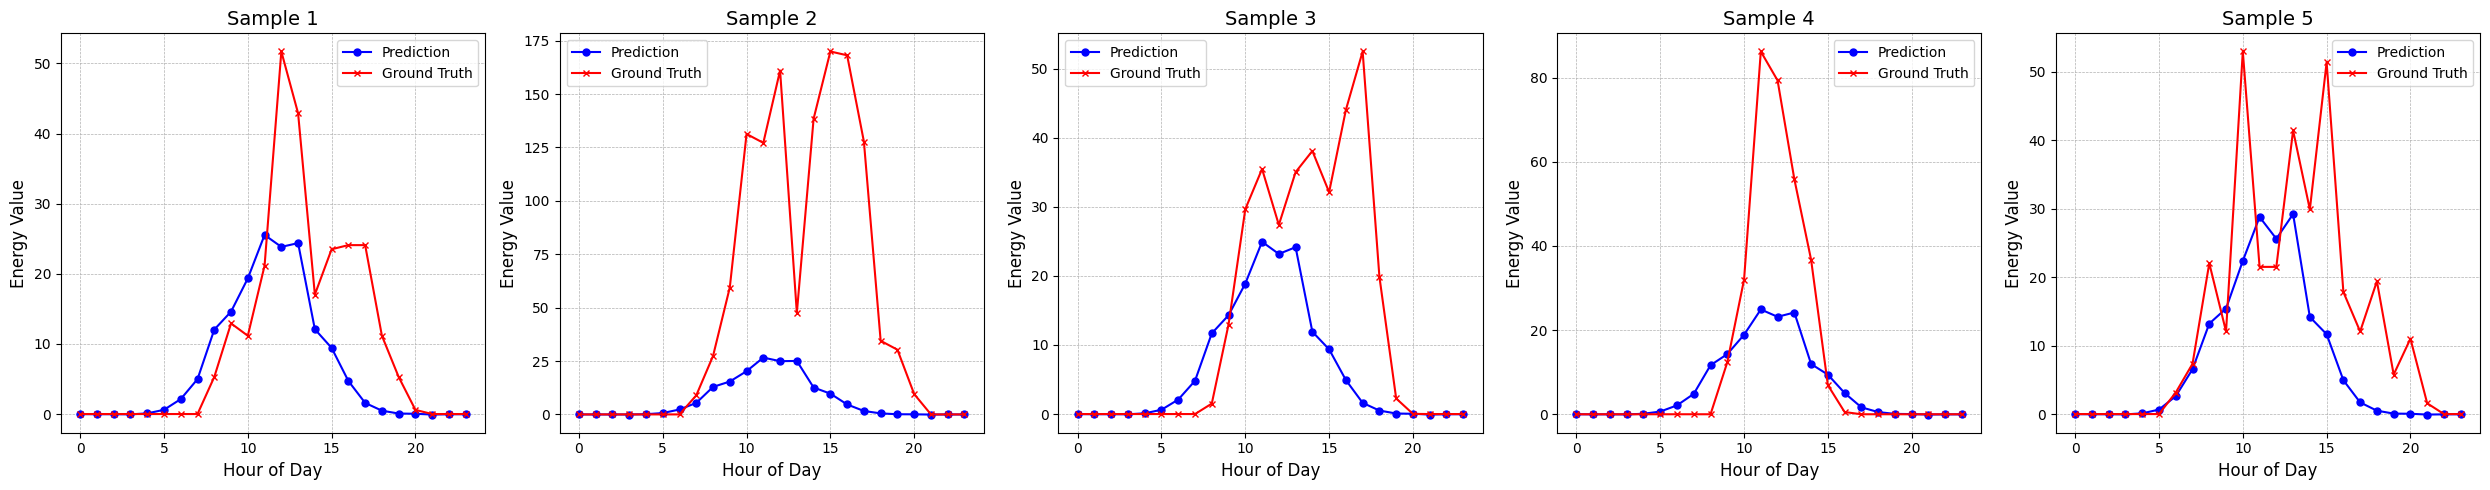

In [143]:
# Load the dataset values
with open('final_models/dataset_values2.pkl', 'rb') as f:
    dataset_values = pickle.load(f)

# Load the trained model
model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size,fc_size, dropout_rate=0.1,dataset_values=dataset_values)
model.load_state_dict(torch.load('final_models/energy_prediction_model2.pth'))
model.eval()

# Load sample data
num_samples = 5
samples_dynamic, samples_static, ground_truth = next(iter(test_measurement_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Ensure normalization and computation are done with tensors
mean_static = torch.tensor(dataset_values['mean'][:2] + [0], dtype=torch.float32) 
std_static = torch.tensor(dataset_values['std'][:2] + [1], dtype=torch.float32)    
mean_dynamic = torch.tensor(dataset_values['mean'][2:], dtype=torch.float32)
std_dynamic = torch.tensor(dataset_values['std'][2:], dtype=torch.float32)

# Apply normalization
samples_static = (samples_static * std_static ) + mean_static
samples_dynamic = (samples_dynamic * std_dynamic) + mean_dynamic

predictions = model.predict(sample_dynamic, sample_static)

# Denormalize function using the dataset's method
def denormalize(data, dataset):
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Denormalize predictions and ground truth
predictions_denorm = predictions
ground_truth_denorm = denormalize(ground_truth.numpy(), dataset)

# Function to plot energy data
def plot_energy_data(predictions, ground_truth, num_samples=5):
    fig, axes = plt.subplots(1,AMOUNT_OF_SAMPLES, figsize=(num_samples * 5,5))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        axes[i].plot(predictions[i], label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        axes[i].plot(ground_truth[i], label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        axes[i].set_title(f'Sample {i+1}', fontsize=14)
        axes[i].set_xlabel('Hour of Day', fontsize=12)
        axes[i].set_ylabel('Energy Value', fontsize=12)
        axes[i].legend()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the energy data for the specified number of samples
plot_energy_data(predictions_denorm, ground_truth_denorm, num_samples=AMOUNT_OF_SAMPLES)

### Hyperparameter optimization 

In [144]:
# import sys 
# sys.exit("Stopping the notebook execution here.")

# Assuming the create_data_loaders function is defined elsewhere
train_loader, val_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    synthetic_sampling_ratio=1,  # 30% of the synthetic dataset
    measured_split_ratio=0.6,    # 50% of the measured dataset for training
    synthetic_split_ratio=0.7,   # 70% of the synthetic dataset for training
    val_ratio=0.2,               # 10% of the training data for validation
    batch_size=64)  

def objective(trial, train_loader, val_loader):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical("hidden_size",[2,4,8,16,32,64])
    fc_size = trial.suggest_categorical("fc_size",[16,32,64,128,256,512])
    loss_type = trial.suggest_categorical("loss_type", ['mse', 'l1', 'huber'])
    # BATCHSIZE = trial.suggest_categorical("batchsize", [8, 16, 32, 64, 128])

    #Update batch size for data loaders
    # train_loader.batch_size = BATCHSIZE
    # val_loader.batch_size = BATCHSIZE

    # Instantiate the model with the suggested hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        fc_size = fc_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        dataset_values=dataset_values
    )
    
    logger = CSVLogger("optuna_logs", name="energy_prediction")
    checkpoint_callback = ModelCheckpoint(
        dirpath="models2/",
        filename="best-model-{epoch:02d}-{val_evaluation_metric:.2f}",
        save_top_k=1,
        verbose=True,
        monitor='val_evaluation_metric',
        mode='min'
    )
    
    trainer = Trainer(
        logger=logger,
        callbacks=[checkpoint_callback],
        max_epochs=5,     
    )
    # Fit the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Use validation loss to determine the best model
    val_loss = trainer.callback_metrics.get("val_evaluation_metric", float('inf'))

    # # Store the best model path in the trial's user attributes
    best_model_path = checkpoint_callback.best_model_path

    if best_model_path: 
        trial.set_user_attr("best_model_path", best_model_path)

    else:
        raise ValueError("Model checkpoint path is empty!")


    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=100, timeout=3600)  # Run for 100 trials or 1 hour


print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("Best model saved to:", trial.user_attrs.get('best_model_path', 'Not available'))
    
print("Best model saved to:", trial.user_attrs['best_model_path'])

[I 2024-06-10 15:14:09,727] A new study created in memory with name: no-name-08d0be70-b595-4476-a8ba-40aeccf64a60
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 543 K 
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
543 K     Trainable params
0         Non-trainable params
543 K     Total params
2.173     Total estimated model params size (MB)


size of the total dataset: 13839 
size of synthetic data: 12497 = 0.90
size of the measured data: 1342 = 0.10

size of the total dataset after subsampling: 13839 
 Size of synthetic data: 12497 = 0.90 
 Size of the measured data: 1342 = 0.10 
 ________________________________________________________

Training set size (synthetic): 6998 = 0.56 of synthetic data
Training set size (measured): 644 = 0.48 of measured data 

Validation set size (synthetic): 1749 = 0.14 of synthetic data
Validation set size (measured): 161 = 0.12 of measured data 

Test set size (synthetic): 3750 = 0.30 of synthetic data
Test set size (measured): 537 = 0.40 of measured data 



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.05725 (best 0.05725), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.06.ckpt' as top 1
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[I 2024-06-10 15:14:22,828] Trial 0 finished with value: 0.057249147444963455 and parameters: {'learning_rate': 0.002767493830834293, 'hidden_size': 2, 'fc_size': 512, 'loss_type': 'mse'}. Best is trial 0 with value: 0.057249147444963455.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdiscipli

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.07698 (best 0.07698), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.08.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.06574 (best 0.06574), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.07.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.06024 (best 0.06024), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.05687 (best 0.05687), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.06.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.05391 (best 0.05391), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.05-v7.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:15:16,434] Trial 1 finished with value: 0.05390807241201401 and parameters: {'learning_rate': 0.0004919166596322929, 'hidden_size': 32, 'fc_size': 32, 'loss_type': 'mse'}. Best is trial 1 with value: 0.05390807241201401.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04582 (best 0.04582), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.04035 (best 0.04035), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03854 (best 0.03854), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.04-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03758 (best 0.03758), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.04-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03741 (best 0.03741), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.04-v6.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:16:10,288] Trial 2 finished with value: 0.03740621358156204 and parameters: {'learning_rate': 0.03340913070340877, 'hidden_size': 16, 'fc_size': 32, 'loss_type': 'huber'}. Best is trial 2 with value: 0.03740621358156204.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.36690 (best 0.36690), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.37.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.36071 (best 0.36071), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.36.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.35405 (best 0.35405), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.34629 (best 0.34629), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.33698 (best 0.33698), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.34.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:17:49,698] Trial 3 finished with value: 0.33698123693466187 and parameters: {'learning_rate': 1.6610869571231937e-05, 'hidden_size': 2, 'fc_size': 64, 'loss_type': 'mse'}. Best is trial 2 with value: 0.03740621358156204.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.04853 (best 0.04853), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 240: 'val_evaluation_metric' reached 0.03603 (best 0.03603), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=01-val_evaluation_metric=0.04.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 360: 'val_evaluation_metric' reached 0.03447 (best 0.03447), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=02-val_evaluation_metric=0.03.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 480: 'val_evaluation_metric' reached 0.03415 (best 0.03415), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=03-val_evaluation_metric=0.03-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 600: 'val_evaluation_metric' reached 0.03251 (best 0.03251), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v36.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-10 15:19:47,468] Trial 4 finished with value: 0.03251497447490692 and parameters: {'learning_rate': 0.015005897883653203, 'hidden_size': 8, 'fc_size': 512, 'loss_type': 'mse'}. Best is trial 4 with value: 0.03251497447490692.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\denni\Documents\5ARIP10 - Interdisciplinary team project\InterdisciplinaryProject\energy_prediction\models2 exists and is not empty.

  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 120: 'val_evaluation_metric' reached 0.12106 (best 0.12106), saving model to 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=00-val_evaluation_metric=0.12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
final_losses = [trial.value for trial in study.trials if trial.value is not None]

# Print the losses
for i, loss in enumerate(final_losses):
    print(f"Trial {i}: Loss = {loss}")

print(study.best_trial)
print(study.best_params)

Trial 0: Loss = 0.03403798118233681
Trial 1: Loss = 0.05090358853340149
Trial 2: Loss = 0.052484095096588135
Trial 3: Loss = 0.053935013711452484
Trial 4: Loss = 0.026293646544218063
Trial 5: Loss = 0.05471372604370117
Trial 6: Loss = 0.055354539304971695
Trial 7: Loss = 0.03514223173260689
Trial 8: Loss = 0.029653077945113182
Trial 9: Loss = 0.05209791287779808
Trial 10: Loss = 0.13924981653690338
Trial 11: Loss = 0.028374018147587776
Trial 12: Loss = 0.18188922107219696
Trial 13: Loss = 0.03307473286986351
Trial 14: Loss = 0.039569489657878876
Trial 15: Loss = 0.03947662562131882
Trial 16: Loss = 0.031904444098472595
Trial 17: Loss = 0.03226937726140022
Trial 18: Loss = 0.0356057770550251
Trial 19: Loss = 0.13924981653690338
Trial 20: Loss = 0.0326620452105999
Trial 21: Loss = 0.03022455796599388
Trial 22: Loss = 0.02991694025695324
Trial 23: Loss = 0.13924981653690338
Trial 24: Loss = 0.03533296659588814
Trial 25: Loss = 0.031364716589450836
Trial 26: Loss = 0.0420178547501564
Trial

In [ ]:
def save_hyperparameters(trial, filename="hyperparameters.txt"):
    with open(filename, "w") as f:
        for key, value in trial.params.items():
            f.write(f"{key}: {value}\n")
            print(f"{key}: {value}")

def load_model(checkpoint_path, trial):
    # Extract hyperparameters from the trial
    learning_rate = trial.params['learning_rate']
    hidden_size = trial.params['hidden_size']
    fc_size = trial.params['fc_size']
    loss_type = trial.params['loss_type']    

    # Instantiate the model with the trial's hyperparameters
    model = TrainEnergyPrediction(
        dynamic_feature_size=5,  
        static_feature_size=3,  
        hidden_size=hidden_size,
        fc_size =fc_size,
        learning_rate=learning_rate,
        loss_type=loss_type,
        dataset_values=dataset_values
    )
    
    # Load the model's weights from the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

def evaluate_model(model, test_loader):
    trainer = Trainer(logger=False)
    results = trainer.test(model, dataloaders=test_loader)
    return results

# Retrieve the best trial
best_trial = study.best_trial
print(best_trial)

# Print all user attributes to debug
print("User attributes of the best trial:", best_trial.user_attrs)

# Check if 'best_model_path' is present
if 'best_model_path' in best_trial.user_attrs:
    checkpoint_path = best_trial.user_attrs['best_model_path']

    # Load the best model
    model = load_model(checkpoint_path, best_trial)
    torch.save(model.state_dict(), f"{checkpoint_path}.pth")
    save_hyperparameters(trial, filename=f"{checkpoint_path}_hyperparams.txt")

    print(f"Evaluating best model from trial {best_trial.number}")

    # Evaluate on both synthetic and measurement test loaders
    model_results = evaluate_model(model, [test_synthetic_loader,test_measurement_loader])
    print("Results for the best model:")
    print("Synthetic Test Set:", model_results)
    
else:
    print("Best model path not found in the best trial's user attributes.")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FrozenTrial(number=40, state=1, values=[0.026280932128429413], datetime_start=datetime.datetime(2024, 6, 10, 14, 33, 23, 593175), datetime_complete=datetime.datetime(2024, 6, 10, 14, 34, 19, 769884), params={'learning_rate': 0.005387181130426583, 'hidden_size': 32, 'fc_size': 512, 'loss_type': 'l1'}, user_attrs={'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdisciplinary team project\\InterdisciplinaryProject\\energy_prediction\\models2\\best-model-epoch=04-val_evaluation_metric=0.03-v20.ckpt'}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'hidden_size': CategoricalDistribution(choices=(2, 4, 8, 16, 32, 64)), 'fc_size': CategoricalDistribution(choices=(16, 32, 64, 128, 256, 512)), 'loss_type': CategoricalDistribution(choices=('mse', 'l1', 'huber'))}, trial_id=40, value=None)
User attributes of the best trial: {'best_model_path': 'C:\\Users\\denni\\Documents\\5ARIP10 - Interdiscipli

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Total L1 loss       │     37.85572814941406     │     68.50373840332031     │
│      Total auc_ratio      │    1.0041295289993286     │    0.8254183530807495     │
│      Total test_loss      │     37.85572814941406     │     68.50373840332031     │
│       test_r2_score       │    0.9128523468971252     │    0.6213898062705994     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

Results for the best model:
Synthetic Test Set: [{'Total test_loss/dataloader_idx_0': 37.85572814941406, 'Total L1 loss/dataloader_idx_0': 37.85572814941406, 'Total auc_ratio/dataloader_idx_0': 1.0041295289993286, 'test_r2_score/dataloader_idx_0': 0.9128523468971252}, {'Total test_loss/dataloader_idx_1': 68.50373840332031, 'Total L1 loss/dataloader_idx_1': 68.50373840332031, 'Total auc_ratio/dataloader_idx_1': 0.8254183530807495, 'test_r2_score/dataloader_idx_1': 0.6213898062705994}]


In [ ]:
# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = denormalize(predictions[i], dataset)
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = model.predict(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

AttributeError: 'TrainEnergyPrediction' object has no attribute 'predict'

In [ ]:
# Denormalize function using the dataset's method
def denormalize(data, dataset):
    data = data.numpy()
    denormalized_data = data * (dataset.output_maxs - dataset.output_mins) + dataset.output_mins
    return denormalized_data

# Function to plot 24-hour energy data for multiple samples
def plot_energy_data(samples, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_y = 
        gt_y = denormalize(ground_truth[i], dataset)
        
        # Plot energy data
        ax.plot(pred_y, label='Prediction', color='blue', linestyle='-', marker='o', markersize=5)
        ax.plot(gt_y, label='Ground Truth', color='red', linestyle='-', marker='x', markersize=5)
        ax.set_title(f'Sample {i+1}', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Energy Value', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Number of samples to plot and subplots configuration
num_samples = 16
rows = 4
cols = 4


# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = model(samples_dynamic, samples_static)

# Plot the 24-hour energy data for the predicted values and ground truth
plot_energy_data(num_samples, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)

SyntaxError: invalid syntax (2990727452.py, line 16)